# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
# !pip install -r requirements.txt

In [1]:
# !pip show eli5

In [2]:
# !pip install --upgrade eli5

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import datetime
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# import eli5
from eli5.sklearn import PermutationImportance

## Data Load

In [50]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = 'train.csv'
test_path  = 'test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
rate = pd.read_csv('rate.csv')

In [51]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', train.shape, 'Test data shape : ', test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [52]:
# # train set에는 없지만 test set에는 있는 아파트 
# train_apt = set(train['아파트명'])
# test_apt = set(test['아파트명'])

# apt_only_in_test = list(test_apt - train_apt)

# apt_only_in_test

In [53]:
# train[train['아파트명']=='현대']

In [54]:
# test[test['아파트명'].isin(apt_only_in_test)][['아파트명', '건축년도', '계약년월']]

In [55]:
# len(test[test['아파트명'].isin(apt_only_in_test)][['아파트명', '건축년도', '계약년월']])
# #>> test set에만 있는 아파트는 test set 전체 9272개 중 72개(0.8%)

## 전처리: 결측치

In [56]:
# train/test 합치기 

train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

In [57]:
concat = pd.merge(concat, rate, left_on='계약년월', right_on='Date', how='left')
concat = concat.drop(columns='Date')

In [58]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', 'rate'],
      dtype='object')

In [59]:
# 전용면적 단순화: 59->60, 84->85, 115->116
concat['전용면적(㎡)'] = concat['전용면적(㎡)'].round(0).astype(int)
concat.loc[concat['전용면적(㎡)']==59, '전용면적(㎡)'] = 60
concat.loc[concat['전용면적(㎡)']==84, '전용면적(㎡)'] = 85
concat.loc[concat['전용면적(㎡)']==115, '전용면적(㎡)'] = 116

In [60]:
# # 칼럼별 value_counts 확인 

# for col in concat.columns:
#     print(col)
#     display(concat[col].value_counts())
    
# #>> 거래유형, 중개사소재지, 건축면적

In [61]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [62]:
# concat 칼럼별 결측치 비율 

missing_values = concat.isnull().sum()  # 칼럼별 결측치 수 
total_rows = concat.shape[0]  # 전체 행 수 
missing_ratio = (missing_values / total_rows) * 100
missing_ratio_sorted = missing_ratio.sort_values(ascending=False)
missing_ratio_df = pd.DataFrame({'Missing Ratio (%)': missing_ratio_sorted})
missing_ratio_df

,Missing Ratio (%)
k-135㎡초과,99.970836
해제사유발생일,99.450844
k-등록일자,98.962143
등기신청일자,98.508724
중개사소재지,96.624306
거래유형,96.308552
단지소개기존clob,93.871433
k-홈페이지,89.843843
고용보험관리번호,81.620592
세대전기계약방법,78.485392


In [63]:
# 결측치 90% 이상 칼럼 제거 
over_90_na_ratio_col = missing_ratio_df[missing_ratio_df['Missing Ratio (%)'] >= 90].index
over_90_na_ratio_col = over_90_na_ratio_col.drop('k-135㎡초과') # 'k-135㎡초과' 칼럼은 drop하지않음
concat = concat.drop(columns=over_90_na_ratio_col)

## 불필요한 칼럼

In [64]:
# 불필요해보이는 칼럼 제거 
cols_to_drop = ['k-홈페이지', '고용보험관리번호', 'k-팩스번호', 'k-전화번호' ]
concat = concat.drop(columns=cols_to_drop)

## 주소 관련 

In [65]:
concat['시군구'].value_counts()

서울특별시 노원구 상계동    45232
서울특별시 노원구 중계동    26524
서울특별시 양천구 신정동    23768
서울특별시 도봉구 창동     23222
서울특별시 구로구 구로동    22941
                 ...  
서울특별시 중구 필동1가        6
서울특별시 용산구 주성동        5
서울특별시 종로구 연지동        4
서울특별시 중구 입정동         3
서울특별시 마포구 구수동        3
Name: 시군구, Length: 339, dtype: int64

In [66]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])
del concat['시군구']

In [67]:
all = list(concat['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [68]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat['강남여부'] = is_gangnam

In [69]:
# 주소 관련 
concat[[ '도로명', '번지','본번','부번', '좌표X', '좌표Y']]
# 번지: 본번+부번
#>> 주소관련: 시군구, 본번 남기고 도로명, 번지, 부번은 drop 

,도로명,번지,본번,부번,좌표X,좌표Y
0,언주로 3,658-1,658.0,1.0,127.05721,37.476763
1,언주로 3,658-1,658.0,1.0,127.05721,37.476763
2,언주로 3,658-1,658.0,1.0,127.05721,37.476763
3,언주로 3,658-1,658.0,1.0,127.05721,37.476763
4,언주로 3,658-1,658.0,1.0,127.05721,37.476763
...,...,...,...,...,...,...
1128089,신내역로1길 85,816,816.0,0.0,127.10672,37.618870
1128090,신내역로1길 85,816,816.0,0.0,127.10672,37.618870
1128091,신내역로1길 85,816,816.0,0.0,127.10672,37.618870
1128092,신내역로1길 85,816,816.0,0.0,127.10672,37.618870


In [70]:
# concat['전용면적(㎡)'] = concat['전용면적(㎡)'].astype(str)
# concat['unique_id'] = concat['동'] + concat['아파트명'] 

In [71]:
# 본번, 부번 칼럼 drop 
add_to_drop = ['도로명', '번지','부번','좌표X', '좌표Y', '동']
concat = concat.drop(columns=add_to_drop)

In [72]:
# concat[['k-난방방식', '건축년도']]

In [73]:
# # 건축년도별 난방방식 비중(난방비중 결측치를 어떻게 채울것인가)
# subset = concat[['건축년도', 'k-난방방식']]
# grouped = subset.groupby(['건축년도', 'k-난방방식']).size().reset_index(name='count')
# pivot = grouped.pivot_table(index='건축년도', columns='k-난방방식', values='count', fill_value=0 )
# pivot = pivot.div(pivot.sum(axis=1), axis=0)*100
# pivot.round(1)

In [74]:
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("\n범주형 변수:", categorical_columns)

연속형 변수: ['본번', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'rate', '강남여부']

범주형 변수: ['아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '구']


<Axes: >

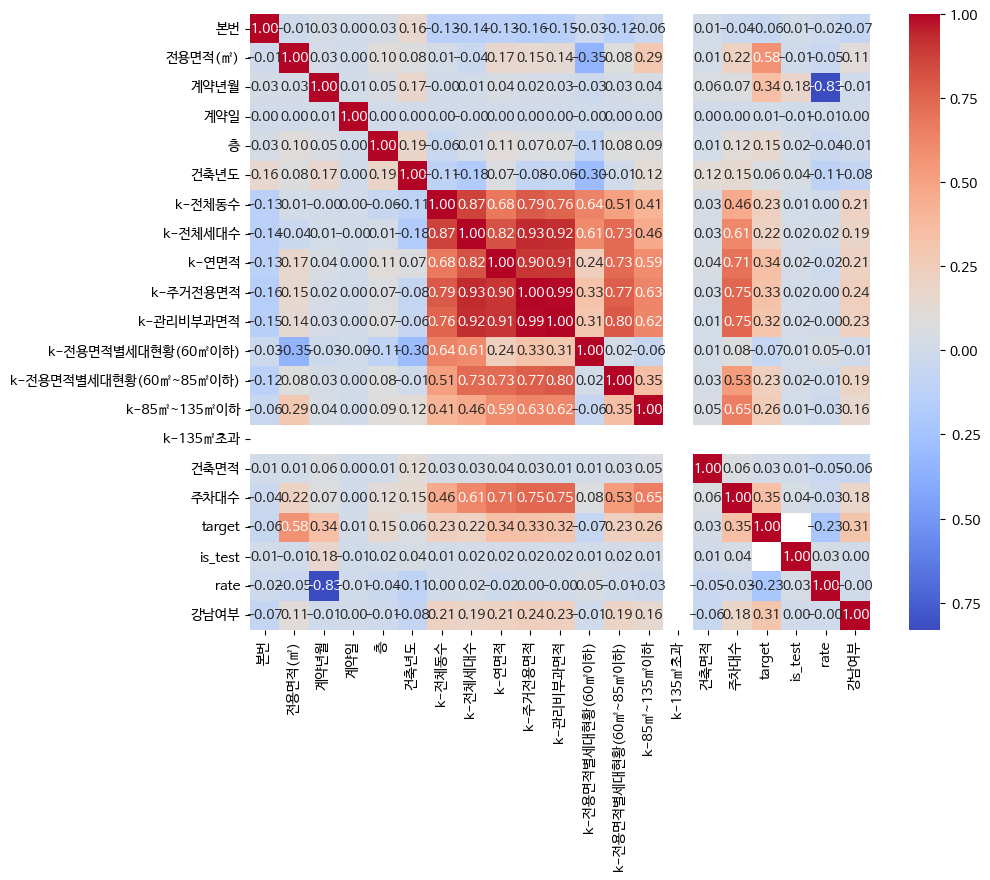

In [75]:
concat_continuous = concat[continuous_columns]
correlation = concat_continuous.corr()

# plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")

In [76]:
# corr 높은 칼럼들: k-전체동수, 주차대수, k-전체세대수, k-주거전용면적, k-관리비부과면적, k-전용면적별세대현황(60㎡~85㎡이하), 


## 면적 관련

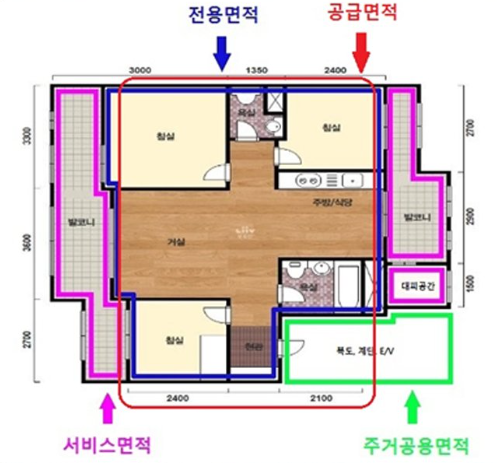

In [77]:
# 면적 관련 칼럼
concat[[ 'k-전체동수', '주차대수', 'k-전체세대수','건축면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-85㎡~135㎡이하', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과', 'k-연면적', '전용면적(㎡)']]
#>> '건축면적': 건물의 1층 바닥 넓이 
#>> '연면적': 건물의 모든 층의 면적을 합한 넓이 

,k-전체동수,주차대수,k-전체세대수,건축면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-85㎡~135㎡이하,k-주거전용면적,k-전용면적별세대현황(60㎡~85㎡이하),k-135㎡초과,k-연면적,전용면적(㎡)
0,8.0,262.0,270.0,4858.0,22637.0,20.0,0.0,20204.0,250.0,NaN,22637.0,80
1,8.0,262.0,270.0,4858.0,22637.0,20.0,0.0,20204.0,250.0,NaN,22637.0,80
2,8.0,262.0,270.0,4858.0,22637.0,20.0,0.0,20204.0,250.0,NaN,22637.0,55
3,8.0,262.0,270.0,4858.0,22637.0,20.0,0.0,20204.0,250.0,NaN,22637.0,80
4,8.0,262.0,270.0,4858.0,22637.0,20.0,0.0,20204.0,250.0,NaN,22637.0,80
...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,16.0,1568.0,1402.0,14171.0,92808.0,808.0,90.0,93849.0,504.0,NaN,190866.0,85
1128090,16.0,1568.0,1402.0,14171.0,92808.0,808.0,90.0,93849.0,504.0,NaN,190866.0,85
1128091,16.0,1568.0,1402.0,14171.0,92808.0,808.0,90.0,93849.0,504.0,NaN,190866.0,102
1128092,16.0,1568.0,1402.0,14171.0,92808.0,808.0,90.0,93849.0,504.0,NaN,190866.0,85


In [78]:
# 면적 관련 칼럼 drop: 'k-전체세대수', '전용면적(㎡)', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)', 'k-85㎡~135㎡이하', 'k-전용면적별세대현황(60㎡~85㎡이하)'만 남기고 제거 
area_to_drop = ['k-전체동수', '주차대수', '건축면적', 'k-관리비부과면적', 'k-주거전용면적' ]
#>> '건축면적': 건물의 1층 바닥 넓이 ]
concat = concat.drop(columns=area_to_drop)

In [79]:
# 면적별 비중으로 하나의 칼럼 만들기
concat[['k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-전체세대수']]

,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-전체세대수
0,20.0,250.0,0.0,NaN,270.0
1,20.0,250.0,0.0,NaN,270.0
2,20.0,250.0,0.0,NaN,270.0
3,20.0,250.0,0.0,NaN,270.0
4,20.0,250.0,0.0,NaN,270.0
...,...,...,...,...,...
1128089,808.0,504.0,90.0,NaN,1402.0
1128090,808.0,504.0,90.0,NaN,1402.0
1128091,808.0,504.0,90.0,NaN,1402.0
1128092,808.0,504.0,90.0,NaN,1402.0


In [80]:
concat['k-전용면적별세대현황(60㎡이하)'] = concat['k-전용면적별세대현황(60㎡이하)'] / concat['k-전체세대수']
concat['k-전용면적별세대현황(60㎡~85㎡이하)'] = concat['k-전용면적별세대현황(60㎡~85㎡이하)'] / concat['k-전체세대수']
concat['k-85㎡~135㎡이하'] = concat['k-85㎡~135㎡이하'] / concat['k-전체세대수']
concat['k-135㎡초과'] = concat['k-135㎡초과'] / concat['k-전체세대수']


In [81]:
concat[['k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-전체세대수']]

,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-전체세대수
0,0.074074,0.925926,0.000000,NaN,270.0
1,0.074074,0.925926,0.000000,NaN,270.0
2,0.074074,0.925926,0.000000,NaN,270.0
3,0.074074,0.925926,0.000000,NaN,270.0
4,0.074074,0.925926,0.000000,NaN,270.0
...,...,...,...,...,...
1128089,0.576320,0.359486,0.064194,NaN,1402.0
1128090,0.576320,0.359486,0.064194,NaN,1402.0
1128091,0.576320,0.359486,0.064194,NaN,1402.0
1128092,0.576320,0.359486,0.064194,NaN,1402.0


In [96]:
area_to_drop = ['k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하']
concat = concat.drop(columns=area_to_drop)

## 일자 관련

In [82]:
# 일자 관련 칼럼
concat[['단지신청일', '단지승인일', 'k-사용검사일-사용승인일', 'k-수정일자', '건축년도', '계약일', '계약년월']]
#>> 'k-수정일자': 불필요 
#>> 'k-사용검사일-사용승인일'(결측치 78%): '건축년도'(결측치 0%)로 대체가능 
#>> '단지신청일': '단지승인일'로 대체
#>> '계약일': 불필요 

,단지신청일,단지승인일,k-사용검사일-사용승인일,k-수정일자,건축년도,계약일,계약년월
0,2022-11-17 10:19:06.0,2022-11-17 13:00:29.0,1987-11-21 00:00:00.0,2023-09-23 17:21:41.0,1987,8,201712
1,2022-11-17 10:19:06.0,2022-11-17 13:00:29.0,1987-11-21 00:00:00.0,2023-09-23 17:21:41.0,1987,22,201712
2,2022-11-17 10:19:06.0,2022-11-17 13:00:29.0,1987-11-21 00:00:00.0,2023-09-23 17:21:41.0,1987,28,201712
3,2022-11-17 10:19:06.0,2022-11-17 13:00:29.0,1987-11-21 00:00:00.0,2023-09-23 17:21:41.0,1987,3,201801
4,2022-11-17 10:19:06.0,2022-11-17 13:00:29.0,1987-11-21 00:00:00.0,2023-09-23 17:21:41.0,1987,8,201801
...,...,...,...,...,...,...,...
1128089,2014-09-01 13:05:03.0,2015-09-09 15:30:27.0,2014-06-18 00:00:00.0,2023-09-23 09:00:52.0,2014,19,202307
1128090,2014-09-01 13:05:03.0,2015-09-09 15:30:27.0,2014-06-18 00:00:00.0,2023-09-23 09:00:52.0,2014,25,202307
1128091,2014-09-01 13:05:03.0,2015-09-09 15:30:27.0,2014-06-18 00:00:00.0,2023-09-23 09:00:52.0,2014,27,202308
1128092,2014-09-01 13:05:03.0,2015-09-09 15:30:27.0,2014-06-18 00:00:00.0,2023-09-23 09:00:52.0,2014,2,202309


In [83]:
# '아파트나이=계약년월-건축년도' 칼럼 생성, 건축년도 칼럼 제거 
concat['계약년'] = concat['계약년월'] // 100
concat['apt_age'] = concat['계약년'] - concat['건축년도']
concat = concat.drop(columns='계약년')
concat['apt_age']

0          30
1          30
2          30
3          31
4          31
           ..
1128089     9
1128090     9
1128091     9
1128092     9
1128093     9
Name: apt_age, Length: 1128094, dtype: int64

In [84]:
# 일자 관련 칼럼 drop: 'k-수정일자', 'k-사용검사일-사용승인일', '단지신청일', '계약일', '건축년도' 제거 
date_to_drop = ['k-수정일자', 'k-사용검사일-사용승인일', '단지신청일', '단지승인일', '계약일', '건축년도', 'k-135㎡초과']
concat = concat.drop(columns=date_to_drop)

In [85]:
pd.set_option('display.max_rows', 100)
concat[['k-관리방식', 'k-전체세대수','전용면적(㎡)',  '아파트명', 'k-건설사(시공사)', 'k-시행사', 'k-난방방식']]

,k-관리방식,k-전체세대수,전용면적(㎡),아파트명,k-건설사(시공사),k-시행사,k-난방방식
0,자치관리,270.0,80,개포6차우성,우성건설,모름,개별난방
1,자치관리,270.0,80,개포6차우성,우성건설,모름,개별난방
2,자치관리,270.0,55,개포6차우성,우성건설,모름,개별난방
3,자치관리,270.0,80,개포6차우성,우성건설,모름,개별난방
4,자치관리,270.0,80,개포6차우성,우성건설,모름,개별난방
...,...,...,...,...,...,...,...
1128089,위탁관리,1402.0,85,신내우디안1단지,한신공영(주),SH공사,개별난방
1128090,위탁관리,1402.0,85,신내우디안1단지,한신공영(주),SH공사,개별난방
1128091,위탁관리,1402.0,102,신내우디안1단지,한신공영(주),SH공사,개별난방
1128092,위탁관리,1402.0,85,신내우디안1단지,한신공영(주),SH공사,개별난방


In [86]:
# 불필요해보이는 칼럼 제거 
col_to_drop = ['k-관리방식', 'k-건설사(시공사)', 'k-시행사', 'k-난방방식', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-복도유형', 
              '관리비 업로드', '사용허가여부' ]
concat = concat.drop(columns=col_to_drop)

In [87]:
# 불필요해보이는 칼럼 추가로 제거 
col_to_drop = ['경비비관리형태', '세대전기계약방법', '청소비관리형태']
concat = concat.drop(columns=col_to_drop)

In [88]:
concat.columns

Index(['본번', '아파트명', '전용면적(㎡)', '계약년월', '층', 'k-전체세대수', 'k-연면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       '기타/의무/임대/임의=1/2/3/4', 'target', 'is_test', 'rate', '구', '강남여부',
       'apt_age'],
      dtype='object')

In [89]:
len(['본번', '아파트명', '전용면적(㎡)', '계약년월', '층', 'k-전체세대수', 'k-연면적',
'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
'단지승인일', 'target', 'is_test', '구', '동', '계약년', 'apt_age'])


22

In [90]:
for col in concat.columns:
    print({col}, {concat[col].nunique()})

{'본번'} {1523}
{'아파트명'} {6549}
{'전용면적(㎡)'} {269}
{'계약년월'} {201}
{'층'} {73}
{'k-전체세대수'} {522}
{'k-연면적'} {735}
{'k-전용면적별세대현황(60㎡이하)'} {464}
{'k-전용면적별세대현황(60㎡~85㎡이하)'} {538}
{'k-85㎡~135㎡이하'} {409}
{'기타/의무/임대/임의=1/2/3/4'} {4}
{'target'} {14530}
{'is_test'} {2}
{'rate'} {160}
{'구'} {25}
{'강남여부'} {2}
{'apt_age'} {74}


In [91]:
concat['전용면적(㎡)'].value_counts()

85     348079
60     230303
116     39504
50      31787
40      19570
        ...  
395         1
424         1
263         1
310         1
268         1
Name: 전용면적(㎡), Length: 269, dtype: int64

In [180]:
# # 이상치 제거 방법에는 IQR을 이용하겠습니다.
# def remove_outliers_iqr(dt, column_name):
#     df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
#     df_test = dt.query('is_test == 1')

#     Q1 = df[column_name].quantile(0.25)
#     Q3 = df[column_name].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

#     result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
#     return result

In [181]:
# # 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
# concat = remove_outliers_iqr(concat, '전용면적(㎡)')

In [94]:
# target 값의 상위 5%에 해당하는 임계값 계산
threshold = concat['target'].quantile(0.95)

# 상위 5%의 'target' 값을 가지는 행들의 '아파트명'을 새로운 리스트에 저장
top_5_pct = concat.loc[concat['target'] > threshold, '아파트명'].unique().tolist()

# '아파트명'이 상위 5%에 해당하는 리스트에 있는지 여부를 나타내는 새로운 칼럼 생성
concat['top_5_pct'] = concat['아파트명'].isin(top_5_pct).astype(int)

concat['top_5_pct']


0          1
1          1
2          1
3          1
4          1
          ..
1128089    0
1128090    0
1128091    0
1128092    0
1128093    0
Name: top_5_pct, Length: 1128094, dtype: int64

In [95]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '전용면적(㎡)', '계약년월', '층', 'k-전체세대수', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'target', 'is_test', 'rate', '강남여부', 'apt_age', 'top_5_pct']
범주형 변수: ['아파트명', '기타/의무/임대/임의=1/2/3/4', '구']


In [93]:
# # 범주형 변수에 대한 보간
# concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

# # 연속형 변수에 대한 보간 (선형 보간)
# concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [97]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 1128093
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   본번                   1128019 non-null  float64
 1   아파트명                 1125958 non-null  object 
 2   전용면적(㎡)              1128094 non-null  int64  
 3   계약년월                 1128094 non-null  int64  
 4   층                    1128094 non-null  int64  
 5   k-전체세대수              251969 non-null   float64
 6   k-연면적                251969 non-null   float64
 7   기타/의무/임대/임의=1/2/3/4  251969 non-null   object 
 8   target               1118822 non-null  float64
 9   is_test              1128094 non-null  int64  
 10  rate                 1128094 non-null  float64
 11  구                    1128094 non-null  object 
 12  강남여부                 1128094 non-null  int64  
 13  apt_age              1128094 non-null  int64  
 14  top_5_pct            1128094 non-null  int64  
dty

# Model Training

In [98]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
concat['계약년월'] = concat['계약년월'].astype(int)
dt_train = concat.query('is_test==0 and 계약년월 >= 202001')
dt_test = concat.query('is_test==1')



# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(156590, 14) (9272, 14)


In [99]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [100]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['본번', '전용면적(㎡)', '계약년월', '층', 'k-전체세대수', 'k-연면적', 'target', 'rate', '강남여부', 'apt_age', 'top_5_pct']
범주형 변수: ['아파트명', '기타/의무/임대/임의=1/2/3/4', '구']


In [101]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(dt_train[col].astype(str))
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    unique_labels_test = pd.unique(dt_test[col])
    for label in unique_labels_test:
        if not isinstance(label, str):  # 숫자인 경우 문자열로 변환
            label = str(label)
        if label not in lbl.classes_:  # unseen label 데이터인 경우
            lbl.classes_ = np.append(lbl.classes_, label)  # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))


100%|██████████| 3/3 [00:00<00:00, 10.71it/s]


In [102]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [103]:
dt_train.columns

Index(['본번', '아파트명', '전용면적(㎡)', '계약년월', '층', 'k-전체세대수', 'k-연면적',
       '기타/의무/임대/임의=1/2/3/4', 'target', 'rate', '구', '강남여부', 'apt_age',
       'top_5_pct'],
      dtype='object')

In [104]:
# pip install optuna

In [105]:
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold
import numpy as np
import xgboost as xgb
from catboost import CatBoostRegressor

# Target과 독립변수들을 분리해줍니다.
y = dt_train['target']
X = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2023)

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 1e-4, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list = []
    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]  # 수정된 부분
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]  # 수정된 부분
        model = xgb.XGBRegressor(**param)
        model.fit(X_train_kf, y_train_kf, eval_set=[(X_val_kf, y_val_kf)], early_stopping_rounds=50, verbose=False)
        preds = model.predict(X_val_kf)
        rmse = np.sqrt(mean_squared_error(y_val_kf, preds))
        rmse_list.append(rmse)
    return np.mean(rmse_list)

# Optuna 스터디 생성
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
best_params = study.best_trial.params
print("Best parameters:", best_params)

[I 2024-03-31 15:35:14,406] A new study created in memory with name: no-name-0788c065-c5f3-4441-b837-a4fa30977770


In [ ]:
from xgboost import XGBRegressor

In [ ]:
best_model = XGBRegressor(**best_params, random_seed=1)
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=None)
pred = best_model.predict(X_val)

[0]	validation_0-rmse:63078.02273
[1]	validation_0-rmse:58460.01153
[2]	validation_0-rmse:54550.63953
[3]	validation_0-rmse:51550.94788
[4]	validation_0-rmse:49449.07330


[5]	validation_0-rmse:47760.46188
[6]	validation_0-rmse:45961.43883
[7]	validation_0-rmse:44341.51079
[8]	validation_0-rmse:43216.23282
[9]	validation_0-rmse:42198.16330
[10]	validation_0-rmse:41040.35919
[11]	validation_0-rmse:40159.91394
[12]	validation_0-rmse:39201.54402
[13]	validation_0-rmse:38418.21453
[14]	validation_0-rmse:38206.56642
[15]	validation_0-rmse:38053.78326
[16]	validation_0-rmse:37538.58380
[17]	validation_0-rmse:36934.28654
[18]	validation_0-rmse:36442.86550
[19]	validation_0-rmse:35875.29192
[20]	validation_0-rmse:35464.43133
[21]	validation_0-rmse:35003.47950
[22]	validation_0-rmse:34806.71060
[23]	validation_0-rmse:34756.00433
[24]	validation_0-rmse:34339.81073
[25]	validation_0-rmse:34328.51610
[26]	validation_0-rmse:33769.60773
[27]	validation_0-rmse:33484.20263
[28]	validation_0-rmse:33361.93766
[29]	validation_0-rmse:33064.60164
[30]	validation_0-rmse:32989.59020
[31]	validation_0-rmse:32975.56884
[32]	validation_0-rmse:32969.82137
[33]	validation_0-rmse:32

In [ ]:
# best_model = CatBoostRegressor(**best_params, random_seed=1)
# best_model.fit(X_train, y_train)
# pred = best_model.predict(X_val)

0:	learn: 54204.1137716	total: 12.4ms	remaining: 6.83s
1:	learn: 44216.1825023	total: 25.2ms	remaining: 6.93s
2:	learn: 38789.5351951	total: 39ms	remaining: 7.13s
3:	learn: 35319.9829766	total: 51.4ms	remaining: 7.04s
4:	learn: 32308.1048546	total: 63.9ms	remaining: 6.99s
5:	learn: 30619.1999635	total: 78.2ms	remaining: 7.12s
6:	learn: 29311.7758902	total: 91.1ms	remaining: 7.09s
7:	learn: 28131.9610526	total: 104ms	remaining: 7.08s
8:	learn: 26960.4245393	total: 117ms	remaining: 7.08s
9:	learn: 26203.4882386	total: 130ms	remaining: 7.06s
10:	learn: 25659.2233277	total: 143ms	remaining: 7.05s
11:	learn: 25230.1254024	total: 156ms	remaining: 7.04s
12:	learn: 24700.1106022	total: 170ms	remaining: 7.03s
13:	learn: 24067.1866016	total: 183ms	remaining: 7.02s
14:	learn: 23458.0702120	total: 196ms	remaining: 7.02s
15:	learn: 23064.8736093	total: 209ms	remaining: 7s
16:	learn: 22845.3297809	total: 222ms	remaining: 6.99s
17:	learn: 22613.0287490	total: 235ms	remaining: 6.97s
18:	learn: 22392.3

In [ ]:
# pip install XGBoost

In [ ]:
# 평가
mse = mean_squared_error(y_val, pred)
rmse = np.sqrt(mse)
rmse

26896.81827730724

<Axes: title={'center': 'Feature Importances'}>

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

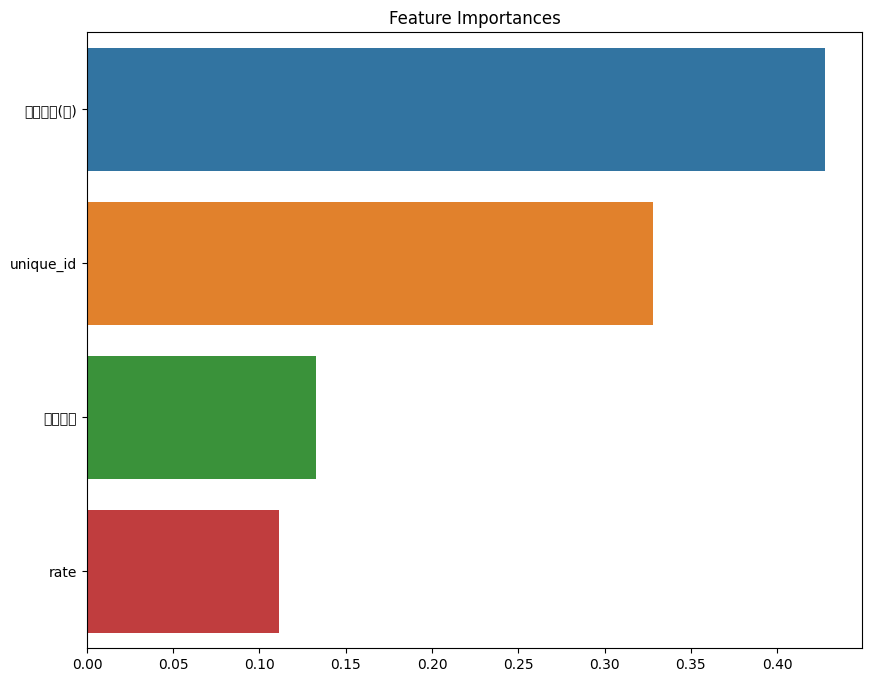

In [ ]:
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)

In [373]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [374]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [375]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 331 ms, sys: 0 ns, total: 331 ms
Wall time: 40.9 ms


In [376]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_14.csv', index=False)

In [ ]:
# GridSearch CV 
from sklearn.model_selection import GridSearchCV, KFold
from catboost import CatBoostRegressor

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'random_strength': [0.5, 1, 1.5]
}

# k-fold 교차 검증
kf = KFold(n_splits=5, shuffle=True, random_state=2023)

best_score = None
best_params = None

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝 및 k-fold 교차 검증
model = CatBoostRegressor(random_seed=1)
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=kf,
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
best_model = CatBoostRegressor(**best_params, random_seed=1)
best_model.fit(X_train, y_train)
val_predictions = best_model.predict(X_val)

In [ ]:
best_model = CatBoostRegressor(**best_params, random_seed=1)
best_model.fit(X_train, y_train)
val_predictions = best_model.predict(X_val)

In [ ]:
# 평가
mse = mean_squared_error(y_val, pred)
rmse = np.sqrt(mse)
rmse

<Axes: title={'center': 'Feature Importances'}, xlabel='None', ylabel='None'>

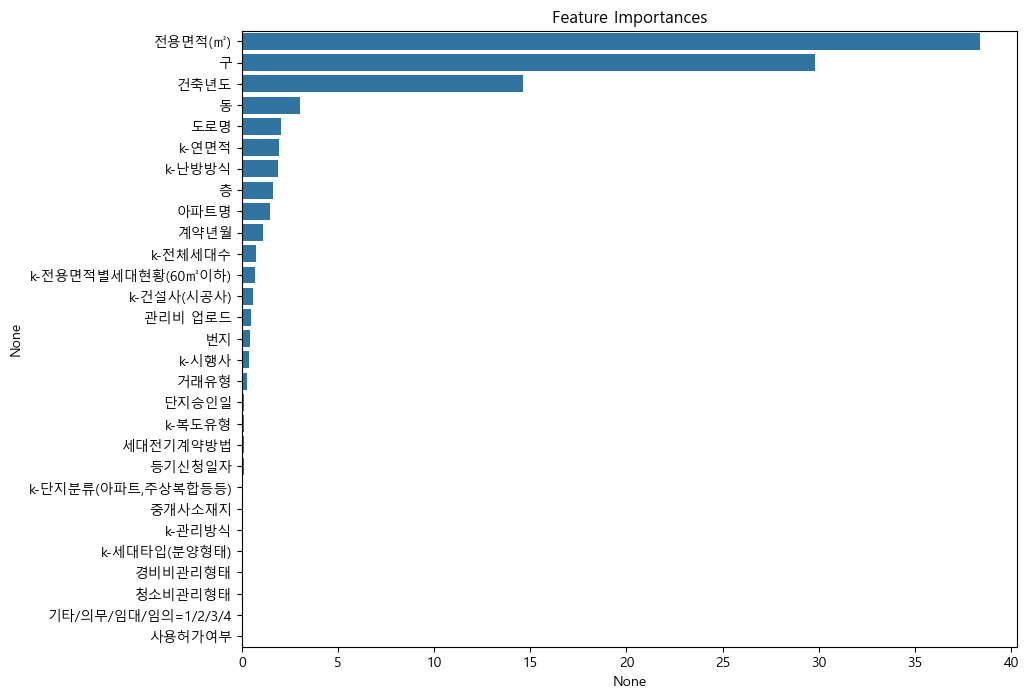

In [105]:
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)

In [106]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [107]:
dt_test.head(2)

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,...,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,target,구,동
0,4711,264,79.9700,202307,5,1987,4418,181,2,0,...,4,1,4,4,719,0,0,0,0,7
1,4712,265,108.2017,202308,10,2021,320,181,1,296,...,2,2,2,2,713,0,0,0,0,7


In [108]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [109]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: total: 0 ns
Wall time: 10.5 ms


In [110]:
real_test_pred       

array([170729.70503215, 284809.78118245, 338745.57845066, ...,
       124267.40801944, 103874.12767453,  85261.854905  ])

In [111]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_9.csv', index=False)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [22]:
subway = pd.read_csv('subway_feature.csv')
bus = pd.read_csv('bus_feature.csv')

In [30]:
train['좌표X']

0          127.057210
1          127.057210
2          127.057210
3          127.057210
4          127.057210
              ...    
1118817    126.905638
1118818    126.905638
1118819    126.905638
1118820    126.905638
1118821    127.000071
Name: 좌표X, Length: 1118822, dtype: float64

In [31]:
bus['X좌표']

0        126.987752
1        126.996566
2        126.998251
3        126.987613
4        127.001744
            ...    
12579    127.139338
12580    127.140046
12581    127.123596
12582    127.125497
12583    127.127337
Name: X좌표, Length: 12584, dtype: float64

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     9272 non-null   object 
 1   번지                      9270 non-null   object 
 2   본번                      9272 non-null   float64
 3   부번                      9272 non-null   float64
 4   아파트명                    9262 non-null   object 
 5   전용면적(㎡)                 9272 non-null   float64
 6   계약년월                    9272 non-null   int64  
 7   계약일                     9272 non-null   int64  
 8   층                       9272 non-null   int64  
 9   건축년도                    9272 non-null   int64  
 10  도로명                     9272 non-null   object 
 11  해제사유발생일                 212 non-null    float64
 12  등기신청일자                  9272 non-null   object 
 13  거래유형                    9272 non-null   object 
 14  중개사소재지                  9272 non-null   